* Formation Continue EMIASD, Univ. Paris Dauphine, Promo 6

* Author: Mohamed-Amine Baazizi
* Affiliation: LIP6 - Faculté des Sciences - Sorbonne Université
* Email: mohamed-amine.baazizi@lip6.fr
* Reusing without consent of the author is strictly forbidden
* July 2025

<p align="center">
  <a href="https://colab.research.google.com/github/auduvignac/Data_Lakehouse/blob/main/notebooks/project/delta_lake_usecase.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Ouvrir dans Google Colab"/>
  </a>
</p>

# Homework


## Outline

This homework is about building an effective data preparation pipeline.
It covers the following aspects covered throughout the session:

* ingest raw data, curate it, transform it
* load the data into delta tables to enforce constraints and allow updates
* chose an optimal data layout to speedup query evaluation

It is based on raw data about car prices crawled from a public source.

You are kindly asked to understand the data and decide about a relevant analysis (2 or 3 analytical queries) that can be performed on this data.
For example, you could suggest to derive insights (min, max, avg) about the price per year of registration.
You can use any other descriptive column that you may find useful.
You are also kindly invited to briefly comment the choices you made at each phase.








## Prerequisite

### System setup

In [1]:
!wget -q https://raw.githubusercontent.com/auduvignac/Data_Lakehouse/refs/heads/main/setup_env.py -O setup_env.py
%run setup_env.py

⚡ Exécution sur Colab : vérification stricte des dépendances…
✅ delta-spark 3.2.1 — OK
✅ parquet-tools 0.2.16 — OK
✅ pyngrok 7.3.0 — OK
✅ pyspark 3.5.3 — OK
✅ Toutes les dépendances satisfont les contraintes.


In [ ]:
%%capture
%pip install pyspark==3.5.3
%pip install -q delta-spark==3.2.1
%pip install pyngrok

In [2]:
!pip list|grep spark

dataproc-spark-connect                0.8.3
delta-spark                           3.2.1
pyspark                               3.5.3


In [3]:
from pyspark import SparkConf

from pyspark.context import SparkContext
from pyspark.sql import SparkSession

local = "local[*]"
appName = "Formation Continue EMIASD - Delta Lake "
localConfig = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "8G").\
  set("spark.driver.memory","8G").\
  set("spark.sql.catalogImplementation","in-memory").\
  set("spark.sql.extensions","io.delta.sql.DeltaSparkSessionExtension").\
  set("spark.sql.catalog.spark_catalog","org.apache.spark.sql.delta.catalog.DeltaCatalog").\
  set("spark.jars.packages","io.delta:delta-spark_2.12:3.1.0").\
  set("spark.databricks.delta.schema.autoMerge.enabled","true")

spark = SparkSession.builder.config(conf = localConfig).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [4]:
spark

### Data import

Before performing any analysis, we need to import the dataset into our working environment.  
This involves three main steps:  
1. Downloading and extracting the dataset archive.  
2. Checking the extracted files to confirm the dataset is available.  
3. Loading the CSV file into a Spark SQL table for further exploration and transformation.  

These steps ensure that the raw data is properly prepared and accessible for the data preparation pipeline.



#### Download and extract dataset

This section aims to fetch the dataset archive from the remote server and extract its contents locally in `/tmp/MLData`.




In [5]:
%%capture
!wget --no-verbose https://nuage.lip6.fr/s/89BG8HD9r3iE693/download/MLData.tgz -O /tmp/MLData.tgz
!tar -xzvf /tmp/MLData.tgz  --directory /tmp/

The command above is used to download and extract the dataset.  
Since the dataset is distributed as a compressed `.tgz` archive, we first fetch it with `wget` and then unpack it into `/tmp/MLData` using `tar`.  
The `%%capture` magic is applied to hide the verbose output and keep the notebook tidy.

#### Check extracted files

This section aims to verify that the dataset has been correctly extracted and explore the available files.


In [6]:
!ls -hal /tmp/MLData

total 73M
drwxr-xr-x 2  501 staff 4.0K Jan  6  2022 .
drwxrwxrwt 1 root root  4.0K Aug 23 07:21 ..
-rw-r--r-- 1  501 staff  66M Jan  6  2022 autos.csv
-rw-r--r-- 1  501 staff  176 Jan  6  2022 ._loan.csv
-rw-r--r-- 1  501 staff 6.8M Jan  6  2022 loan.csv


The command above lists the contents of `/tmp/MLData` along with file sizes.
From here, we confirm the presence of `autos.csv`, which is the main dataset we will use for our analysis.

#### Load dataset into Spark table

The following query aims to create a Spark SQL table from the raw CSV file so that we can query the data efficiently.

```sql
CREATE TABLE IF NOT EXISTS raw_vehiculePrices
USING csv
OPTIONS (
  header "true",
  path "/tmp/MLData/autos.csv",
  inferSchema "true"
)
```

We define a new table `raw_vehiculePrices` using the CSV file `autos.csv`.

- `header "true"` ensures the first row is used as column names ;
- `inferSchema "true"` allows Spark to automatically detect column data types ;

This creates a structured table in Spark SQL, making it easier to explore and transform the dataset in the next steps.

In [7]:
query = """
CREATE TABLE IF NOT EXISTS raw_vehiculePrices
USING csv
OPTIONS (
  header "true",
  path "/tmp/MLData/autos.csv",
  inferSchema "true"
)
"""
spark.sql(query)

DataFrame[]

## Phase 0: Understanding the data






In this part, you are invited to get some knowledge about the data by reading its schema and extracting  some basic statistical information about the values of columns that you will find interesting.

### Schema exploration

#### Objective

Before analyzing the data, we want to understand its structure. The `DESCRIBE` command shows the schema of the table, including column names, data types, and roles.

#### Query

```sql
DESCRIBE raw_vehiculePrices
```

In [8]:
query = """
DESCRIBE raw_vehiculePrices
"""
spark.sql(query).show()

+-------------------+---------+-------+
|           col_name|data_type|comment|
+-------------------+---------+-------+
|        dateCrawled|timestamp|   NULL|
|               name|   string|   NULL|
|             seller|   string|   NULL|
|          offerType|   string|   NULL|
|              price|      int|   NULL|
|             abtest|   string|   NULL|
|        vehicleType|   string|   NULL|
| yearOfRegistration|      int|   NULL|
|            gearbox|   string|   NULL|
|            powerPS|      int|   NULL|
|              model|   string|   NULL|
|          kilometer|      int|   NULL|
|monthOfRegistration|      int|   NULL|
|           fuelType|   string|   NULL|
|              brand|   string|   NULL|
|  notRepairedDamage|   string|   NULL|
|        dateCreated|timestamp|   NULL|
|       nrOfPictures|      int|   NULL|
|         postalCode|      int|   NULL|
|           lastSeen|timestamp|   NULL|
+-------------------+---------+-------+



#### Explanation

The dataset contains 20 columns, such as `yearOfRegistration`, `price`, `kilometer`, `brand`, and `fuelType`.
We observe a mix of:

- **Numerical columns**: `price`, `powerPS`, `kilometer`, `yearOfRegistration` ;
- **Categorical columns**: `brand`, `fuelType`, `gearbox`, `vehicleType` ;
- **Timestamps**: `dateCrawled`, `dateCreated`, `lastSeen`.

This confirms the dataset is rich enough for meaningful analysis of vehicle prices and characteristics.

### Data Preview: Sample Rows from the Dataset

#### Objective

Before diving into detailed statistics, we want to preview a few sample rows of the dataset.  
This helps us understand the raw structure, check how values are formatted (e.g., prices, dates, categorical fields),  
and spot any obvious anomalies or missing values directly in the data.

#### Query

```sql
SELECT *
FROM raw_vehiculePrices TABLESAMPLE (5 ROWS);
```

In [9]:
query = """
SELECT * FROM raw_vehiculePrices TABLESAMPLE (5 ROWS);
"""
spark.sql(query).show()

+-------------------+--------------------+------+---------+-----+------+-----------+------------------+---------+-------+-----+---------+-------------------+--------+----------+-----------------+-------------------+------------+----------+-------------------+
|        dateCrawled|                name|seller|offerType|price|abtest|vehicleType|yearOfRegistration|  gearbox|powerPS|model|kilometer|monthOfRegistration|fuelType|     brand|notRepairedDamage|        dateCreated|nrOfPictures|postalCode|           lastSeen|
+-------------------+--------------------+------+---------+-----+------+-----------+------------------+---------+-------+-----+---------+-------------------+--------+----------+-----------------+-------------------+------------+----------+-------------------+
|2016-03-24 11:52:17|          Golf_3_1.6|privat|  Angebot|  480|  test|       NULL|              1993|  manuell|      0| golf|   150000|                  0|  benzin|volkswagen|             NULL|2016-03-24 00:00:00|     

#### Explanation

The preview confirms that the dataset contains diverse information about car listings:

- Timestamps such as `dateCrawled`, `dateCreated`, and `lastSeen` record when the ad was collected and updated ;
- Vehicle details include `name`, `brand`, `model`, `yearOfRegistration`, `gearbox`, `fuelType`, `kilometer`, and `powerPS` ;
- Market-related attributes include `price`, `seller`, `offerType`, and `notRepairedDamage` ;
- Some fields contain missing values (e.g., `vehicleType = NULL`, `model = NULL`), and unrealistic values are already visible (e.g., `powerPS = 0`) ;
- The column `nrOfPictures` is always 0 in the sample, which suggests it may not provide useful information.  

This sample illustrates both the richness of the dataset and the data quality issues (nulls, zeros, possible encoding problems like special characters in names) that will need to be addressed during cleaning.

### Year of registration

#### Objective

We want to identify the range and central tendency of the `yearOfRegistration` column to check for anomalies and understand the distribution of registration years.

#### Query

```sql
SELECT  min(yearOfRegistration), max(yearOfRegistration),
        avg(yearOfRegistration), median(yearOfRegistration)
FROM raw_vehiculePrices
```

In [10]:
query = """
SELECT  min(yearOfRegistration), max(yearOfRegistration),
          avg(yearOfRegistration), median(yearOfRegistration)
FROM raw_vehiculePrices
"""
spark.sql(query).show()

+-----------------------+-----------------------+-----------------------+--------------------------+
|min(yearOfRegistration)|max(yearOfRegistration)|avg(yearOfRegistration)|median(yearOfRegistration)|
+-----------------------+-----------------------+-----------------------+--------------------------+
|                   1000|                   9999|     2004.5767206439623|                    2003.0|
+-----------------------+-----------------------+-----------------------+--------------------------+



#### Explanation

* Min = 1000 → invalid year ;
* Max = 9999 → invalid future year ;
* Average ≈ 2004.6 ;
* Median = 2003.

This shows that the majority of cars are from the 2000s, but the column also contains strong outliers that must be removed for correct analysis.

### Year of registration

#### Objective

We want to explore the distribution of `yearOfRegistration` to confirm where most cars are concentrated and detect abnormal entries.

#### Query

```sql
SELECT yearOfRegistration, count(*)
FROM raw_vehiculePrices
GROUP BY yearOfRegistration
ORDER BY yearOfRegistration DESC
```

In [11]:
query = """
SELECT  yearOfRegistration, count(*)
FROM raw_vehiculePrices
GROUP BY yearOfRegistration
order by 1 desc,2 desc
"""
spark.sql(query).show(150)

+------------------+--------+
|yearOfRegistration|count(1)|
+------------------+--------+
|              9999|      27|
|              9996|       1|
|              9450|       1|
|              9229|       1|
|              9000|       5|
|              8888|       2|
|              8500|       1|
|              8455|       1|
|              8200|       1|
|              8000|       2|
|              7800|       1|
|              7777|       1|
|              7500|       2|
|              7100|       1|
|              7000|       4|
|              6500|       1|
|              6200|       1|
|              6000|       6|
|              5911|       2|
|              5900|       1|
|              5600|       1|
|              5555|       2|
|              5300|       1|
|              5000|      18|
|              4800|       1|
|              4500|       2|
|              4100|       1|
|              4000|       3|
|              3800|       1|
|              3700|       1|
|         

#### Explanation

* Unrealistic years are present (9999, 3000, 1500, etc.).
* Most records are within **1950-2019**, which is a realistic range.
* Highest counts are between **1995-2010**, with a peak around 2000.
* Few entries exist for 2018-2019, probably because of the dataset's collection date.

This suggests we should keep only registrations in a valid range (e.g. 1950-2019) for further analysis.

To gain deeper insights, it is useful to visualize the distribution of the year of registration.

#### Bar Plot of Vehicle Registrations by Year

The observed interval is extremely wide. Since the previous query revealed that `yearOfRegistration` ranges from 1000 to 9999, it is necessary to filter out unrealistic values.  
For the analysis, we restrict the data to the realistic range of 1950-2019.

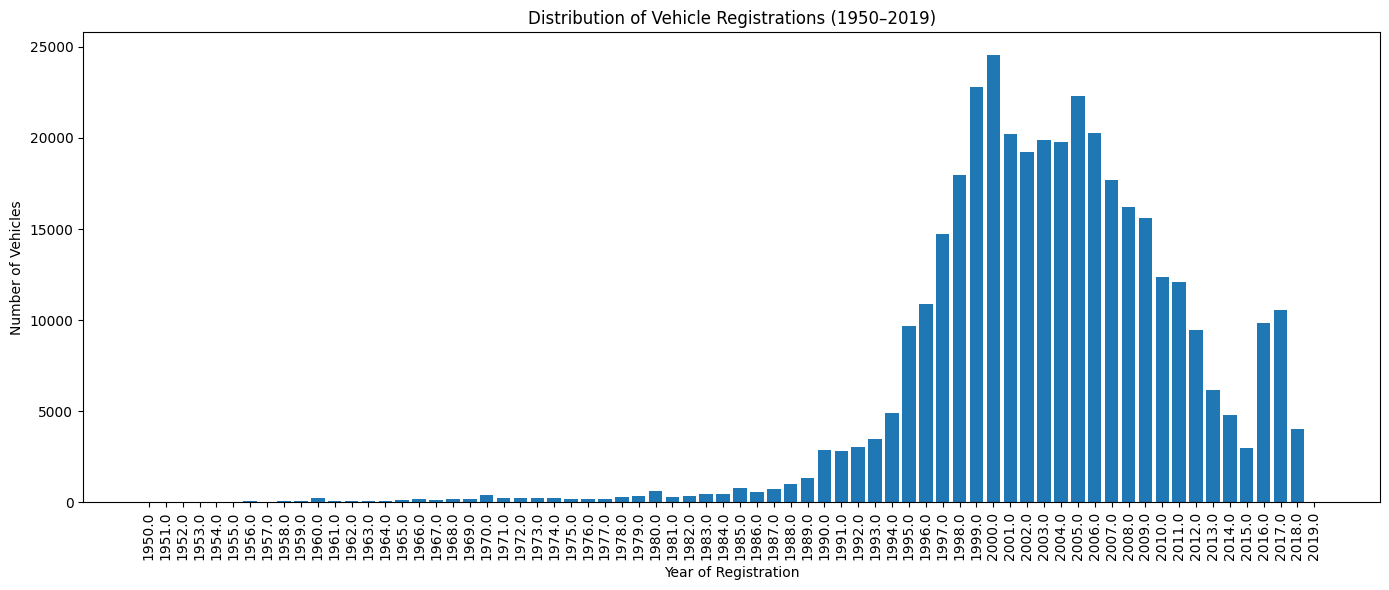

In [15]:
import matplotlib.pyplot as plt

# Run the query and convert to Pandas for plotting
df_years = spark.sql("""
SELECT yearOfRegistration, count(*) as count
FROM raw_vehiculePrices
GROUP BY yearOfRegistration
ORDER BY yearOfRegistration
""").toPandas()

# Filter unrealistic years, e.g. keep only 1950–2019
df_years = df_years[(df_years["yearOfRegistration"] >= 1950) &
                    (df_years["yearOfRegistration"] <= 2019)]

# Plot
plt.figure(figsize=(14,6))
plt.bar(df_years["yearOfRegistration"].astype(str), df_years["count"])
plt.xticks(rotation=90)
plt.xlabel("Year of Registration")
plt.ylabel("Number of Vehicles")
plt.title("Distribution of Vehicle Registrations (1950–2019)")
plt.tight_layout()
plt.show()

The bar plot above shows the distribution of vehicles by year of registration, restricted to the realistic range 1950-2019.  
We observe that:  
- Very few vehicles are registered before 1980, as expected for older cars ;
- The number of registrations increases steadily from the mid-1980s, peaking around 1995-2010 ;
- After 2010, the counts decline, with only a small number of cars from 2018-2019, likely due to the dataset's collection period.  

This visualization confirms the earlier statistical findings: most cars in the dataset are relatively modern, with a strong concentration in the 1995-2010 range.

### Price

#### Objective

We want to analyze car prices by computing minimum, maximum, average, and median values to detect unrealistic entries and identify a central tendency.

#### Query

```sql
SELECT min(price), max(price),
       avg(price), median(price)
FROM raw_vehiculePrices
```

In [16]:
query = """
SELECT  min(price), max(price),
          avg(price), median(price)
FROM raw_vehiculePrices
"""
spark.sql(query).show()

+----------+----------+------------------+-------------+
|min(price)|max(price)|        avg(price)|median(price)|
+----------+----------+------------------+-------------+
|         0|2147483647|17286.338865535483|       2950.0|
+----------+----------+------------------+-------------+



#### Explanation

- Min = 0 → invalid ;
- Max = 2,147,483,647 → unrealistic (max integer value) ;
- Average ≈ 17,286 → skewed by outliers ;
- Median = 2,950 → more representative of used car prices.

Outliers strongly affect the mean, so the **median is a better measure**. Cleaning is needed to remove 0 and excessively high prices.

### Kilometer

#### Objective

We want to analyze the mileage of vehicles (`kilometer`) to understand usage levels and check for potential capping or anomalies.

#### Query

```sql
SELECT min(kilometer), max(kilometer),
       avg(kilometer), median(kilometer)
FROM raw_vehiculePrices
```



In [17]:
query = """
SELECT  min(kilometer), max(kilometer),
          avg(kilometer), median(kilometer)
FROM raw_vehiculePrices
"""
spark.sql(query).show()

+--------------+--------------+------------------+-----------------+
|min(kilometer)|max(kilometer)|    avg(kilometer)|median(kilometer)|
+--------------+--------------+------------------+-----------------+
|          5000|        150000|125618.56044408226|         150000.0|
+--------------+--------------+------------------+-----------------+



#### Explanation

- Min = 5,000 → suspicious (new cars should have values closer to 0) ;
- Max = 150,000 → capped value, suggesting a data limit ;
- Average ≈ 125,619 ;
- Median = 150,000 → indicates at least half of the vehicles are at the maximum cap.

This shows that most vehicles in the dataset are **high-mileage** and that the column is truncated at 150,000 km.

### Global summary

The dataset contains a rich set of categorical and numerical features.
Data quality issues exist:

- Invalid years of registration (1000, 9999, etc.) ;
- Invalid prices (0 or extremely large).
- Mileage capped at 150,000.

Some patterns are observed:

- Most cars were registered between 1995-2010.
- Typical prices cluster around €3,000.
- Vehicles are generally high-mileage.

These insights confirm the need for **data cleaning** before deeper analysis. After cleaning, we will be able to analyze relationships such as:

- Price per year of registration.
- Price differences by brand or fuel type.
- Effect of mileage on price.

## Phase 1: Cleaning the data and selecting relevant columns

In this part you are invited to decide which columns are useful for you analysis and to perform some cleaning on the data by removing outlier values (e.g. remove records with strange values for a specific column).
The result of your cleaning and selection should be stored in a table called `phase1`

Give a brief summary of your choices.

Based on everything we saw in the exploration section here's a structured plan:

### Columns to Keep

These columns are relevant for analyzing car prices and patterns:

- `price`: target of analysis, must be cleaned of invalid values (0, unrealistic highs) ;
- `yearOfRegistration` : key for trends; filter to realistic range (1950-2019) ;
- `kilometer`: indicates usage level, despite capping at 150,000.
- `powerPS`: engine power; keep but filter out zeros and unrealistic values (e.g., > 500-600 PS may be extreme for most cars) ;
- `fuelType`: categorical feature, useful for grouping (diesel, benzin, etc.).
- `gearbox`: categorical, relevant for analysis (manual vs automatic).
- `vehicleType`: useful categorical (SUV, coupe, etc.), despite some nulls ;
- `brand`: essential categorical (BMW, Audi, VW, etc.) ;
- `notRepairedDamage`: categorical, may affect price (yes/no).

### Columns to Drop (less relevant / redundant)

- `dateCrawled`, `dateCreated`, `lastSeen`: technical crawling metadata, not useful for price analysis ;
- `name`: unstructured text, too noisy for this homework's scope.
- `abtest`: internal A/B testing flag, irrelevant ;
- `seller`: mostly “privat” (not informative) ;
- `offerType`: almost always “Angebot” (not informative) ;
- `nrOfPictures`: always 0 in sample, useless ;
- `postalCode`: location info, could be interesting but too granular for now (can be dropped unless geographical analysis is needed) ;
- `monthOfRegistration`: redundant with `yearOfRegistration`, too fine-grained.

### Cleaning Rules (to apply before saving `phase1`)

- `yearOfRegistration`: keep only 1950-2019 ;
- `price`: remove records where `price <= 100` or `price >= 100000` (the threshold will be adjusted in order to determine the most suitable value) ;
- `kilometer`: already capped at 150,000 : keep but note limitation.
- `powerPS`: remove outliers (e.g., `powerPS < 10` or `powerPS > 500`).
- Categorical values: filter out nulls where appropriate (e.g., brand).

So the **final cleaned table `phase1`** should include:


- `price`;
- `yearOfRegistration`;
- `kilometer`;
- `powerPS`;
- `fuelType`;
- `gearbox`;
- `vehicleType`;
- `brand`;
-`notRepairedDamage`.

The following query will be used:

```sql
CREATE OR REPLACE TABLE phase1 AS
SELECT
    price,
    yearOfRegistration,
    kilometer,
    powerPS,
    fuelType,
    gearbox,
    vehicleType,
    brand,
    notRepairedDamage
FROM raw_vehiculePrices
WHERE
    -- keep only realistic years
    yearOfRegistration BETWEEN 1950 AND 2019
    -- filter price (remove too low / too high)
    AND price BETWEEN 100 AND 100000
    -- filter engine power
    AND powerPS BETWEEN 10 AND 500
    -- remove null brands
    AND brand IS NOT NULL
```

In [23]:
from pyspark.sql.functions import col

# Apply cleaning with DataFrame API
phase1_df = (
    spark.table("raw_vehiculePrices")
    .select(
        "price",
        "yearOfRegistration",
        "kilometer",
        "powerPS",
        "fuelType",
        "gearbox",
        "vehicleType",
        "brand",
        "notRepairedDamage"
    )
    .where(
        (col("yearOfRegistration").between(1950, 2019)) &
        (col("price").between(100, 100000)) &
        (col("powerPS").between(10, 500)) &
        (col("brand").isNotNull())
    )
)

# Save as a managed Spark SQL table called phase1
phase1_df.write.mode("overwrite").saveAsTable("phase1")

In [24]:
spark.sql("DESCRIBE phase1").show()
spark.sql("SELECT COUNT(*) FROM phase1").show()

+------------------+---------+-------+
|          col_name|data_type|comment|
+------------------+---------+-------+
|             price|      int|   NULL|
|yearOfRegistration|      int|   NULL|
|         kilometer|      int|   NULL|
|           powerPS|      int|   NULL|
|          fuelType|   string|   NULL|
|           gearbox|   string|   NULL|
|       vehicleType|   string|   NULL|
|             brand|   string|   NULL|
| notRepairedDamage|   string|   NULL|
+------------------+---------+-------+

+--------+
|count(1)|
+--------+
|  321442|
+--------+




## Phase 2: Organizing the data

In this part you are invited to load the data into delta tables where you will define meaningful constraints and conditions to be fulfiled by any future incoming data.
The result of this phase should a delta table called `deltaPrices`

Comment on the constraints you added

....

## Phase 3: Analysing the data and ensuring query evaluation effeciency

Suggest 2 or 3 meaningfull queries as described above and suggest a data organization scheme for optimizing one such query of your choice.

In [ ]:
import getpass

from pyngrok import conf, ngrok

print("Enter your authtoken, which can be copied "
"from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()

ui_port = 4040
public_url = ngrok.connect(ui_port).public_url
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{ui_port}\"")

## Ingesting new data and reruning analytics  

In this part you are invited to suggest the insertion of fictious new data that conforms to the schema established in phase 2 and to rerun some queries of phase 3 to see the evolution of the result. Ideally, write a query that compares an aggregation value in two different versions of the data by exploiting the delta history feature.